# RaspberryShakes at Kennedy Space Center

## Background

When I visited KSC from May 17-21, 2021, I discovered I had left two devices running in Robert's lab. These are:
- R37BE: My original 50Hz RS from the kickstarter
- RCD29: A 100Hz RS&B
Upon further investigation, I found they were both logging data locally, and this was also being copied successfully by cronjob to USB flash drive, and Seedlink server data forwarding to the RShake server was also enabled.

What follows below are steps to retrieve data and instrument responses from the RShake server, and correct and plot those data. 

However, the data on that server had significant dropouts. So there is also a bash script to rsync the data directly from local archive on the devices (assuming the ip addresses do not change) and to load, correct and plot those data.

Note that the 2 fixed ip addresses on each device do not seem to be accessible. Neither are the web interfaces responsive. I can only login to them via ssh to the ip addresses saved in the bash script. These are:

R37BE / RS / 128.217.250.104
RCD29 / RS&B / 128.217.252.92

## To do

It would be good to modify the cronjobs on the devices such that the USB flash drive is only mounted right before data is copied from the local archive, and then unmounted after. And do this on the hour. Or perhaps just once a day, at local midnight. This would mean I could pull the USB flash drives at any time, and swap them if necessary, without having to use a keyboard and monitor. This would be really helpful for field operations. The cronjob would also need to be smart enough to only copy data if the USB flash drive is present and mounted.

## Load data from RShake server and remove instrument response

AM R37BE 00 SHZ
AM RCD29 00 EHZ
AM RCD29 00 HDF


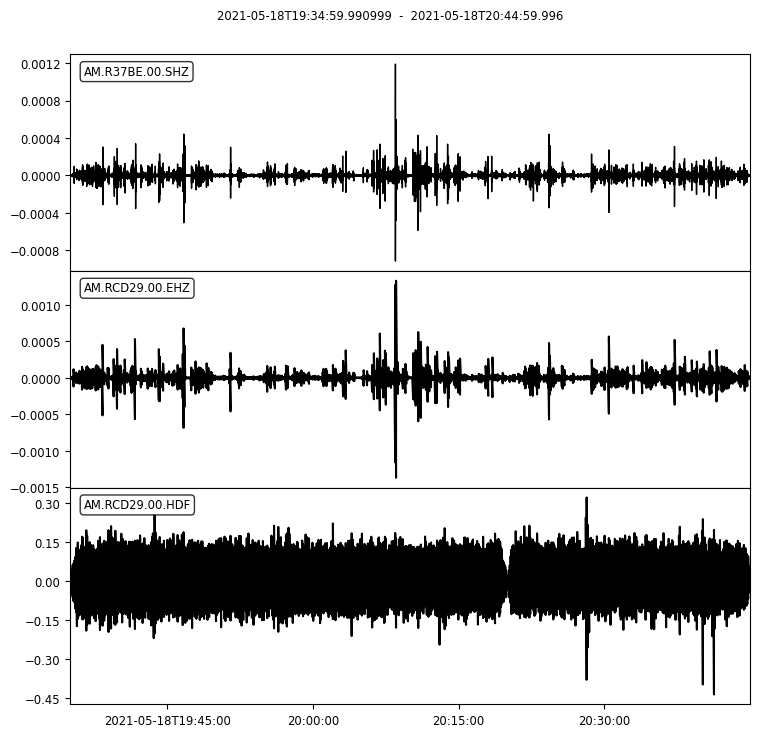

In [100]:
# import dependencies
from obspy import read_inventory, read
from obspy.clients.fdsn import Client
from obspy.core.utcdatetime import UTCDateTime

# set the FDSN server location, and start/end times
rs = Client(base_url='https://fdsnws.raspberryshakedata.com/')
startt = UTCDateTime(2021, 5, 18, 17, 35, 0)+60*60*2
endt = UTCDateTime(2021, 5, 18, 17, 45, 0)+60*60*3

# set the station name and download the response information
inv = {}
nslc = ['AM.R37BE.00.SHZ', 'AM.RCD29.00.EHZ', 'AM.RCD29.00.HDF']
allst = Stream()
for this_nslc in nslc:   
    (net, sta, loc, chan) = this_nslc.split('.')
    print(net, sta, loc, chan)
    try:
        inv[sta] = read_inventory('https://fdsnws.raspberryshakedata.com/fdsnws/station'\
            '/1/query?network=AM&station=%s&level=resp&format=xml' % (sta))
    except:
        print('No inventory found')
    else:
        try:
            st = rs.get_waveforms(net, sta, loc, chan, startt, endt)
        except:
            print('No waveform data found')
        else:
            st.attach_response(inv[sta])
            st.filter('highpass', freq=0.5, corners=2, zerophase=True)
            st = st.remove_response()
            for tr in st:
                allst.append(tr)

allst.plot(equal_scale=False);

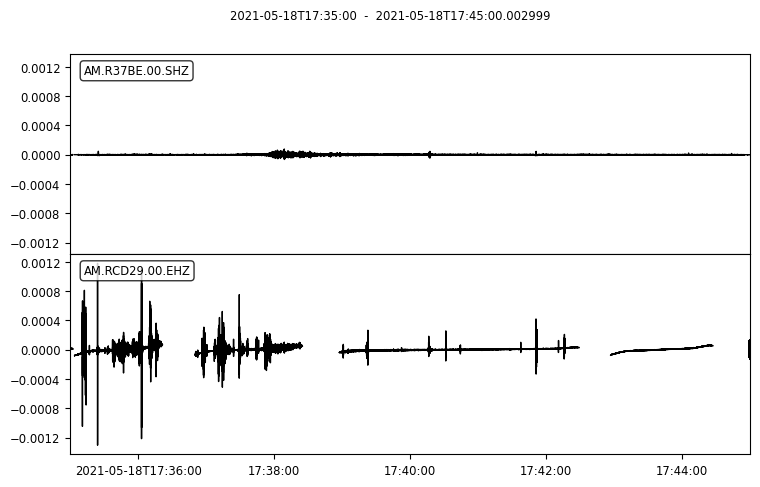

In [78]:
allst.select(channel='?HZ').plot();

# Create/Update local archive via rsync from remote RShakes at KSC

In [1]:
# run get_rshake_data.sh from the command line.

# Load data from local archive - tends to have fewer dropouts

R37BE
Inventory created at 2021-05-19T18:41:23.683388Z
	Sending institution: SeisComP (RaspberryShake)
	Contains:
		Networks (1):
			AM
		Stations (5):
			AM.R37BE (Raspberry Shake Citizen Science Station) (5x)
		Channels (5):
			AM.R37BE.00.SHZ (5x)
R37BE
Inventory created at 2021-05-19T18:41:23.683388Z
	Sending institution: SeisComP (RaspberryShake)
	Contains:
		Networks (1):
			AM
		Stations (5):
			AM.R37BE (Raspberry Shake Citizen Science Station) (5x)
		Channels (5):
			AM.R37BE.00.SHZ (5x)
R37BE
Inventory created at 2021-05-19T18:41:23.683388Z
	Sending institution: SeisComP (RaspberryShake)
	Contains:
		Networks (1):
			AM
		Stations (5):
			AM.R37BE (Raspberry Shake Citizen Science Station) (5x)
		Channels (5):
			AM.R37BE.00.SHZ (5x)
R37BE
Inventory created at 2021-05-19T18:41:23.683388Z
	Sending institution: SeisComP (RaspberryShake)
	Contains:
		Networks (1):
			AM
		Stations (5):
			AM.R37BE (Raspberry Shake Citizen Science Station) (5x)
		Channels (5):
			AM.R37BE.00.SHZ (

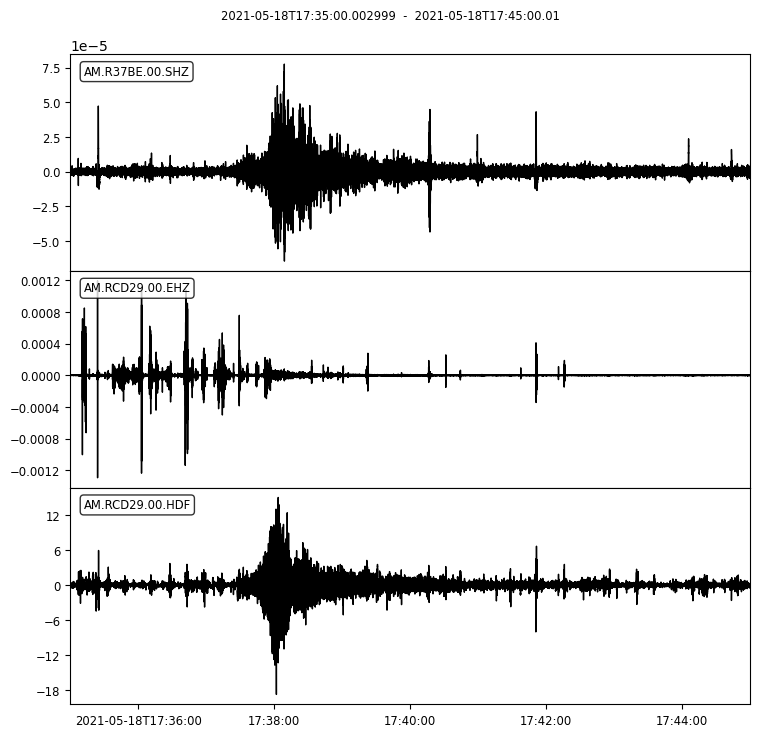

In [83]:
RSHAKE_TOPDIR = './rshake'
year = '2021'
jday = '138'
nslc = ['AM.R37BE.00.SHZ', 'AM.RCD29.00.EHZ', 'AM.RCD29.00.HDF']

from obspy.core import read, Stream
st_all = Stream()
for this_nslc in nslc:
    (net, sta, loc, chan) = this_nslc.split('.')
    RSHAKE_ARCHIVE = os.path.join(RSHAKE_TOPDIR, year, net, sta, '%s.D' % chan)
    try:
        filename = '%s/%s.D.%s.%s' % (RSHAKE_ARCHIVE, this_nslc, year, jday)
        print('Trying to load %s' % filename)
        st = read(filename)
    except:
        print('Could not load')
    else:
        for tr in st:
            st_all.append(tr)

st = st_all.copy()
st.filter('highpass', freq=0.5, corners=2, zerophase=True)
st_corrected = Stream()
for tr in st:
    sta = tr.stats.station
    tr_corrected = tr.remove_response(inventory=inv[sta])
    st_corrected.append(tr_corrected)
st_corrected.trim(starttime=startt, endtime=endt)
st_corrected.plot(equal_scale=False);

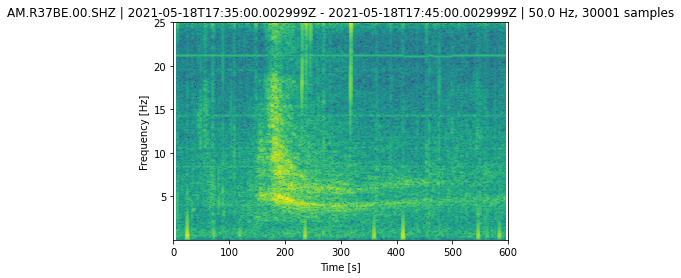

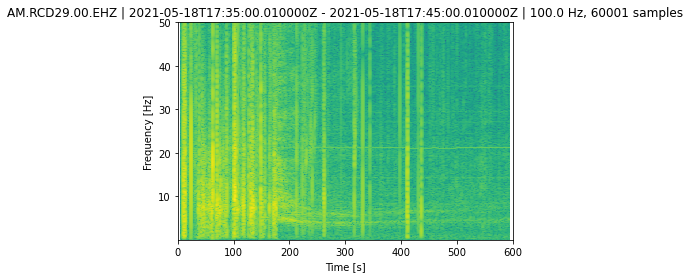

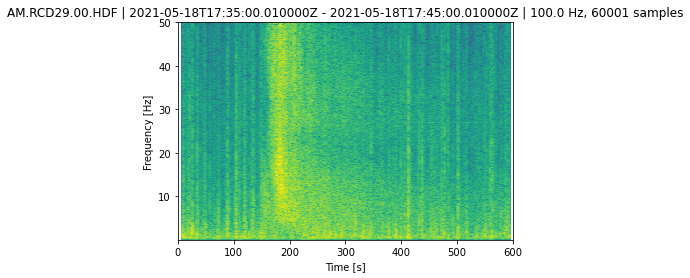

[None, None, None]

In [92]:
 st_corrected.spectrogram(dbscale=True, log=False, per_lap=0.9, wlen=10) # 4 seconds